In [3]:
from google.colab import files
uploaded = files.upload()

Saving Agriculture.csv to Agriculture.csv


In [4]:
import pandas as pd
df = pd.read_csv('Agriculture.csv')
print(df.head())
print(df.info())

   Farm_ID   Soil_pH  Soil_Moisture  Temperature_C  Rainfall_mm Crop_Type  \
0        1  7.073643      49.145359      26.668157   227.890912     Wheat   
1        2  6.236931      21.496115      29.325342   244.017493   Soybean   
2        3  5.922335      19.469042      17.666414   141.110521      Corn   
3        4  6.845120      27.974234      17.188722   156.785663     Wheat   
4        5  6.934171      33.637679      23.603899    77.859362      Corn   

   Fertilizer_Usage_kg  Pesticide_Usage_kg  Crop_Yield_ton  \
0           131.692844            2.958215        1.576920   
1           136.370492           19.204770        3.824686   
2            99.725210           11.041066        1.133198   
3           194.832396            8.806271        8.870540   
4            57.271267            3.747553        8.779317   

   Sustainability_Score  
0             51.913649  
1             47.159077  
2             50.148418  
3             89.764557  
4             51.033941  
<class '

   Farm_ID   Soil_pH  Soil_Moisture  Temperature_C  Rainfall_mm Crop_Type  \
0        1  7.073643      49.145359      26.668157   227.890912     Wheat   
1        2  6.236931      21.496115      29.325342   244.017493   Soybean   
2        3  5.922335      19.469042      17.666414   141.110521      Corn   
3        4  6.845120      27.974234      17.188722   156.785663     Wheat   
4        5  6.934171      33.637679      23.603899    77.859362      Corn   

   Fertilizer_Usage_kg  Pesticide_Usage_kg  Crop_Yield_ton  \
0           131.692844            2.958215        1.576920   
1           136.370492           19.204770        3.824686   
2            99.725210           11.041066        1.133198   
3           194.832396            8.806271        8.870540   
4            57.271267            3.747553        8.779317   

   Sustainability_Score  
0             51.913649  
1             47.159077  
2             50.148418  
3             89.764557  
4             51.033941  
<class '

/tmp/ipython-input-588194394.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_filled.fillna(method='ffill').fillna(method='bfill')


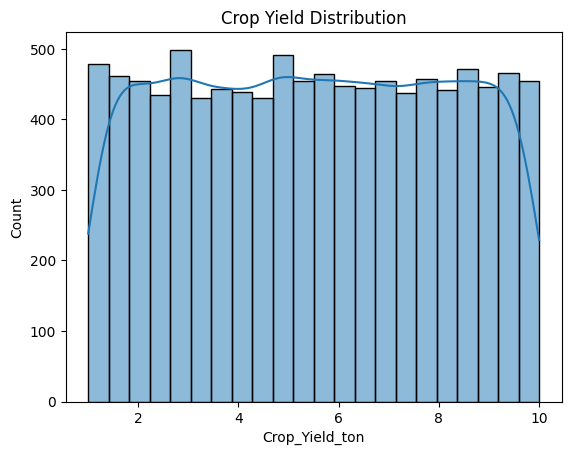

Shapes -> Train: (7000, 10) Val: (1500, 10) Test: (1500, 10)


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = pd.read_csv('Agriculture.csv')

print(df.head())
print(df.info())
print(df.describe())
print("Missing values:\n", df.isnull().sum())

df_filled = df.fillna(df.mean(numeric_only=True))
df_filled = df_filled.fillna(method='ffill').fillna(method='bfill')
print("Missing after fill:\n", df_filled.isnull().sum())

le = LabelEncoder()
for col in df_filled.select_dtypes(include=['object']).columns:
    df_filled[col] = le.fit_transform(df_filled[col])

sns.histplot(df_filled.select_dtypes(include=[np.number])['Crop_Yield_ton'], kde=True)
plt.title('Crop Yield Distribution')
plt.show()

scaler = StandardScaler()
num_cols = df_filled.select_dtypes(include=[np.number]).columns
df_filled[num_cols] = scaler.fit_transform(df_filled[num_cols])

train, temp = train_test_split(df_filled, test_size=0.3, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=42)

print("Shapes -> Train:", train.shape, "Val:", val.shape, "Test:", test.shape)

train.to_csv('train.csv', index=False)
val.to_csv('val.csv', index=False)
test.to_csv('test.csv', index=False)


Week 2(Assignment)


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

df = pd.read_csv('Agriculture.csv')
print("Columns available:", df.columns.tolist())

df_processed = df.copy()

df_processed.drop(columns=['Farm_ID'], errors='ignore', inplace=True)

num_cols = df_processed.select_dtypes(include=[np.number]).columns.drop('Crop_Yield_ton', errors='ignore')
imputer = SimpleImputer(strategy='median')
df_processed[num_cols] = imputer.fit_transform(df_processed[num_cols])

le = LabelEncoder()
if 'Crop_Type' in df_processed.columns:
    df_processed['Crop_Type'] = le.fit_transform(df_processed['Crop_Type'])

scaler = StandardScaler()
df_processed[num_cols] = scaler.fit_transform(df_processed[num_cols])

X_final = df_processed.values

threshold = 5.0
y_clf = (df['Crop_Yield_ton'] >= threshold).astype(int)

clf = RandomForestClassifier(n_estimators=200, random_state=42)
cv_clf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf_scores = cross_val_score(clf, X_final, y_clf, cv=cv_clf, scoring='accuracy')

print("Classification (High vs Low) Accuracy: %.2f%% ± %.2f%%" %
      (clf_scores.mean() * 100, clf_scores.std() * 100))

y_reg = df['Crop_Yield_ton']

reg = RandomForestRegressor(n_estimators=200, random_state=42)
cv_reg = KFold(n_splits=5, shuffle=True, random_state=42)
reg_scores = cross_val_score(reg, X_final, y_reg, cv=cv_reg, scoring='r2')

print("Regression R²: %.3f ± %.3f" %
      (reg_scores.mean(), reg_scores.std()))

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_reg, test_size=0.2, random_state=42
)

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Test R²:", r2_score(y_test, y_pred))
print("Test RMSE:", rmse)

Columns available: ['Farm_ID', 'Soil_pH', 'Soil_Moisture', 'Temperature_C', 'Rainfall_mm', 'Crop_Type', 'Fertilizer_Usage_kg', 'Pesticide_Usage_kg', 'Crop_Yield_ton', 'Sustainability_Score']
Classification (High vs Low) Accuracy: 99.99% ± 0.02%
Regression R²: 1.000 ± 0.000
Test R²: 0.9999998459541738
Test RMSE: 0.0010229470014443338
